C:\Users\longrun\miniconda3\envs\metenv\lib\site-packages\proplot\figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


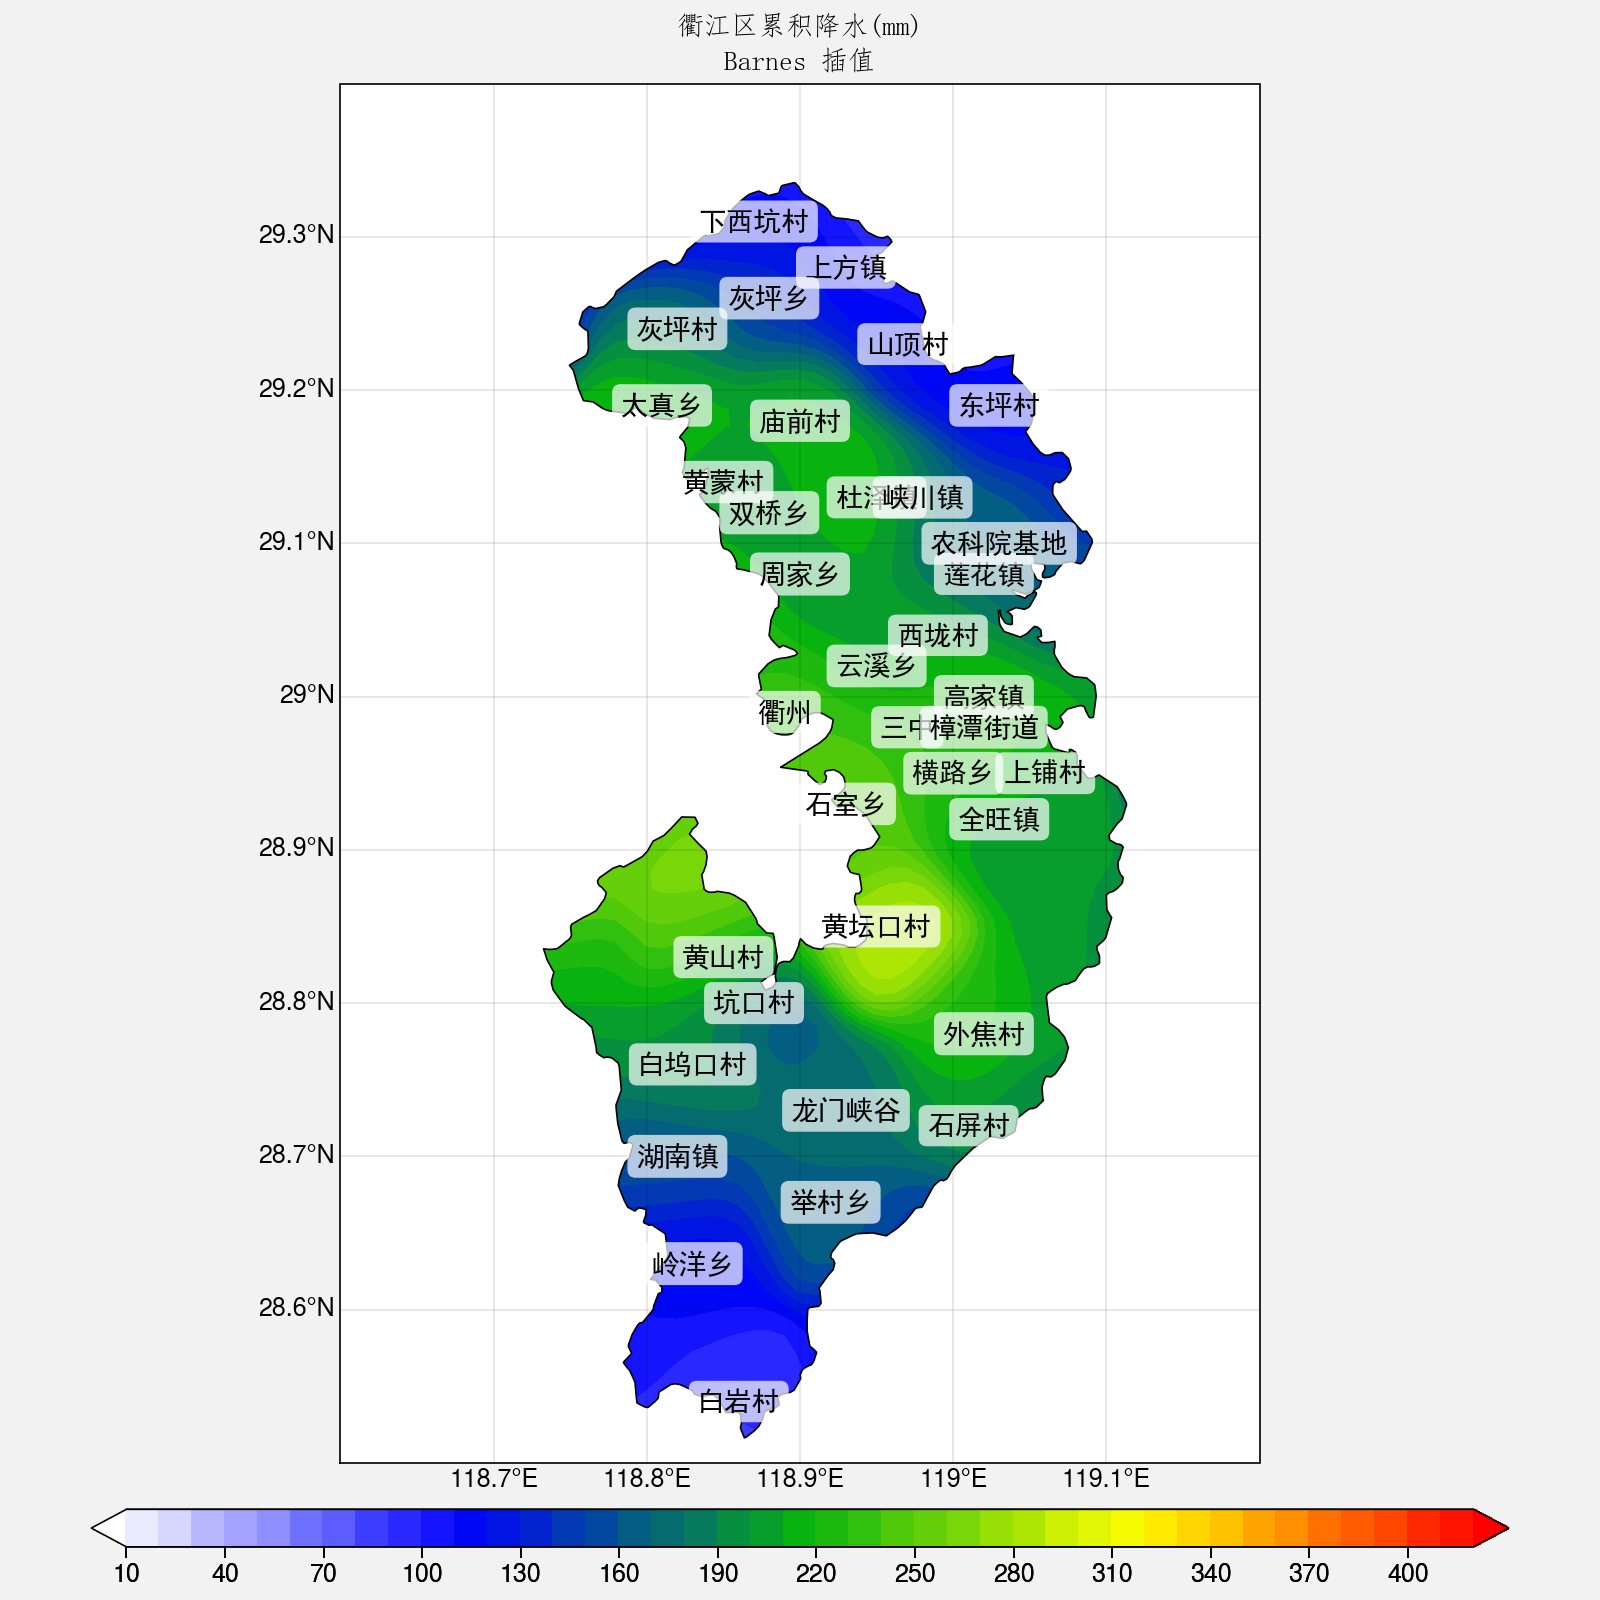

In [61]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.path import Path
import xarray as xr
import proplot as plot
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.mpl.patch import geos_to_path
from cartopy.feature import ShapelyFeature
from shapely.geometry import MultiPolygon
from metpy.interpolate import interpolate_to_grid,natural_neighbor_to_grid
import cmaps

class TDT(cimgt.GoogleWTS):
    def _image_url(self, tile):
        x, y, z = tile
        # url = 'http://t3.tianditu.gov.cn/DataServer?T=vec_w&x=%s&y=%s&l=%s&tk=a4ee5c551598a1889adfabff55a5fc27'% (x, y, z)
        url = 'https://webst01.is.autonavi.com/appmaptile?x=%s&y=%s&z=%s&style=7'% (x, y, z)
        return url


fname = 'shapefiles/浙江省.shp'
shape_records = Reader(fname,encoding='gbk').records()

chn_geoms = []
qz_geoms  = []
qj_geoms  = []
for country in shape_records:
    name_city = country.attributes['行政区划_1'].rstrip('\x00')
    name      = country.attributes['行政区划_2'].rstrip('\x00')
    chn_geoms += [country.geometry]
    if name_city == '衢州市':
        qz_geoms  += [ country.geometry ]
    if name      == '衢江区':
        qj_geoms  += [ country.geometry ]
chn_geoms = MultiPolygon(chn_geoms)
qz_geoms  = MultiPolygon(qz_geoms)
qj_geoms  = MultiPolygon(qj_geoms)
path_qz   = Path.make_compound_path(*geos_to_path(qz_geoms))
path_qj   = Path.make_compound_path(*geos_to_path(qj_geoms))

# 定义中文字体
cnfont = {'fontname':'simhei'}
cnfont_f = {'fontname':'fangsong'}


filename = 'pcp.xlsx'
# 读取excel
df       = pd.read_excel(filename,names=['name','lon','lat','pre'],sheet_name=0)
df       = df.drop_duplicates(subset=['lon','lat'])
df       = df.dropna()
# print(df[(df['lon'] > 119.2) & (df['lon'] < 119.3) & (df['lat'] > 29) & (df['lat'] < 29.1)])

# 插值
lon, lat, pre = interpolate_to_grid(df['lon'], df['lat'], df['pre'], interp_type='barnes', hres=0.01,minimum_neighbors=3,
                                    gamma=0.5,search_radius=0.2)

f, axs = plot.subplots(ncols=1, nrows=1, figsize=(8,8),proj='pcarree' )
axs.format(
    labels=True,dms=False,latlines=0.1, lonlines=0.1,lonlim=(118.6, 119.2),latlim=(28.5, 29.4),
#    labels=True,dms=False,latlines=0.1, lonlines=0.1,lonlim=(118.5, 119.5),latlim=(28.5, 29.4),
    suptitle='衢江区累积降水(mm)',**cnfont_f
)


# im = axs[0].scatter(df['lon'].values, df['lat'].values, marker='o', c=df['pre'].values, s=50, lw=0.7, cmap=cmaps.WhBlGrYeRe, levels=51,edgecolors='k')
# axs[0].colorbar(im, loc='b', length=0.9,)
# axs[0].format(title='站点', **cnfont_f)

levels = [0,0.1,10,25,50,75,100,125,150,175,200,225,250,275,300]
# 画填色图
im = axs[0].contourf(lon, lat, pre, cmap=cmaps.WhBlGrYeRe, levels=51, extend='both') # precip3_16lev
for collection in im.collections:
    collection.set_clip_path(path_qj, ccrs.PlateCarree()._as_mpl_transform(axs[0]))
axs[0].colorbar(im, loc='b', length=0.9)
axs[0].format(title='Barnes 插值', **cnfont_f)

# 提取衢江区域内站点
points = np.array((df['lon'], df['lat'])).T
mask   = path_qj.contains_points(points)
df_qj  = df[mask]

for index, row in df_qj.iterrows():
# 站点降水
#    axs[0].text(row['lon'], row['lat'], "{:.1f}".format(row['pre']), bbox=dict(boxstyle="round,pad=0.3",ec='none',fc='white',alpha=0.7),va='center',ha='center',color='k', fontsize=10)
# 站名
    axs[0].text(row['lon'], row['lat'], row['name'], bbox=dict(boxstyle="round,pad=0.3",ec='none',fc='white',alpha=0.7),va='center',ha='center',color='k', fontsize=10, **cnfont)
        
    

# shapfile
shape_feature = ShapelyFeature(qj_geoms, ccrs.PlateCarree(), facecolor='none',edgecolor='k')
axs.add_feature(shape_feature)